In [50]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.linear_model import LinearRegression
import numpy as np
from regression_model import RegressionModel
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, LSTM
from LSTM_model import LSTMModel

ImportError: No module named tensorflow

In [44]:
df = pd.read_csv('data/Gold.csv')
df.tail()

,Unnamed: 0,Daily_Return,EMA10,EMA100,EMA100Cross,EMA10Cross,EMA12,EMA12Cross,EMA20,EMA20Cross,...,SMA15Cross,SMA20,SMA20Cross,SMA5,SMA50,SMA50Cross,SMA5Cross,Settle_Price,Time,Volume
10972,12/4/2019,-0.003046,1318.427611,1308.988215,0,0,1318.710813,0,1319.847607,0,...,0,1321.430,0,1320.62,1327.696,0,0,1313.4,11073,2352
10973,15/4/2019,-0.010845,1316.786228,1308.996369,0,0,1317.278380,0,1318.852597,0,...,0,1321.050,0,1320.56,1327.086,0,0,1309.4,11074,2647
10974,16/4/2019,-0.000386,1312.861459,1308.723174,1,0,1313.881706,0,1316.599969,0,...,0,1320.535,0,1318.46,1326.456,0,0,1295.2,11075,2819
10975,17/4/2019,-0.000463,1309.559375,1308.445487,0,0,1310.930675,0,1314.514257,0,...,0,1319.050,0,1312.24,1325.596,0,0,1294.7,11076,1677
10976,18/4/2019,0.000000,1306.748580,1308.161418,0,0,1308.341340,0,1312.570042,0,...,0,1317.795,0,1304.80,1324.724,0,0,1294.1,11077,1130


In [45]:
columns = list(df.columns)
numerics = [x for x in columns[2:-3] if 'Cross' not in x and x != 'MACD']

In [38]:
for col in numerics:
    df[col+'norm'] = df[col] / df['Settle_Price'] - 1

In [39]:
columns = list(df.columns)
features = [col for col in columns if 'norm' in col]

In [40]:
X = df[features]
Y = df['Daily_Return']

In [41]:
trainsplit = int(len(Y) * 0.9)
validsplit = trainsplit #+ int(len(Y) * 0.1)
Xtrain = X[:trainsplit]
Ytrain = Y[:trainsplit]
Xvalid = X[trainsplit:validsplit]
Yvalid = Y[trainsplit:validsplit]
Xtest = X[validsplit:]
Ytest = Y[validsplit:]

In [42]:
Xtrain

,EMA10norm,EMA100norm,EMA12norm,EMA20norm,EMA26norm,EMA50norm,SMA10norm,SMA100norm,SMA15norm,SMA20norm,SMA5norm,SMA50norm
0,-0.012585,0.016623,-0.015177,-0.020269,-0.020491,-0.012158,-0.020881,0.016623,-0.027769,-0.029772,-0.007830,-0.013692
1,-0.001863,0.026697,-0.004142,-0.009085,-0.009505,-0.001773,-0.006593,0.026258,-0.014029,-0.017802,0.007253,-0.004187
2,0.009389,0.039616,0.007755,0.003761,0.003455,0.011112,0.009243,0.039432,0.001596,-0.003758,0.024165,0.008140
3,0.012771,0.045112,0.011817,0.008999,0.008924,0.016663,0.015238,0.045227,0.008852,0.002913,0.026779,0.013132
4,0.029929,0.068302,0.030126,0.029604,0.030225,0.038973,0.040138,0.069209,0.032798,0.026806,0.043807,0.035505
5,0.014462,0.054490,0.015121,0.015701,0.016637,0.025568,0.025892,0.055711,0.019452,0.014249,0.018017,0.021711
6,0.019425,0.062867,0.020652,0.022612,0.024016,0.033579,0.033505,0.064448,0.028778,0.024214,0.018868,0.029800
7,0.007397,0.051009,0.008677,0.011034,0.012578,0.022147,0.020713,0.052581,0.017355,0.013639,0.000453,0.017838
8,0.008391,0.052922,0.009764,0.012579,0.014307,0.024065,0.020091,0.054484,0.018994,0.016515,0.000000,0.019410
9,0.000362,0.043739,0.001527,0.004159,0.005844,0.015365,0.007264,0.045203,0.010773,0.008024,-0.010473,0.009752


In [33]:
Ytrain.values

array([-0.0103317 , -0.01318681, -0.00612472, ..., -0.00074349,
       -0.01388889,  0.00385647])

In [8]:
model = RegressionModel()
model.train(Xtrain, Ytrain)

Text(0,0.5,'Predicted returns')

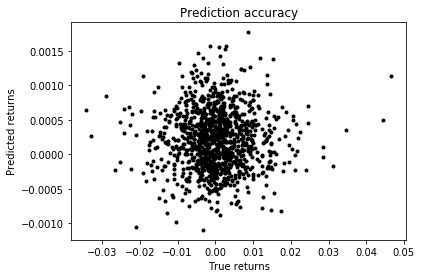

In [9]:
predicted_returns = model.predict(Xtest)
plt.plot(Ytest, predicted_returns, 'k.')
plt.title("Prediction accuracy")
plt.xlabel("True returns")
plt.ylabel("Predicted returns")

In [10]:
strongest_signal = np.max(predicted_returns)
Ytest = Ytest.values

In [11]:
# Long Only Portfolio
portfolio_weight = 1.0
portfolio_over_time = [1.0]
returns = []
max_bet_pct = 1.0 # Percent of holdings to risk on the best bet
for t in range(len(predicted_returns)):
    r_pred = predicted_returns[t]
    r_true = Ytest[t]
    if r_pred < 0:
        portfolio_over_time.append(portfolio_weight)
        returns.append(0.0)
        continue
        
    bet_size_pct = max_bet_pct * r_pred / strongest_signal
    bet_size_portfolio = portfolio_weight * bet_size_pct
    portfolio_weight = portfolio_weight + bet_size_portfolio * r_true
    portfolio_over_time.append(portfolio_weight)
    returns.append(r_true * bet_size_portfolio / portfolio_weight)

In [12]:
portfolio_weight

1.0092778505269269

Text(0,0.5,'Current:Original Holdings Ratio')

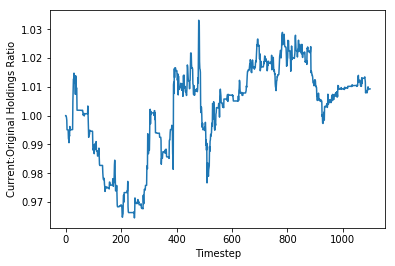

In [13]:
plt.plot(portfolio_over_time)
plt.xlabel("Timestep")
plt.ylabel("Current:Original Holdings Ratio")

(array([  1.,   2.,   0.,   4.,   3.,   4.,  16.,  38.,  79., 677., 168.,
         58.,  21.,  12.,   7.,   3.,   2.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.01409475, -0.01265764, -0.01122053, -0.00978341, -0.0083463 ,
        -0.00690919, -0.00547207, -0.00403496, -0.00259785, -0.00116073,
         0.00027638,  0.0017135 ,  0.00315061,  0.00458772,  0.00602484,
         0.00746195,  0.00889906,  0.01033618,  0.01177329,  0.0132104 ,
         0.01464752,  0.01608463,  0.01752175,  0.01895886,  0.02039597,
         0.02183309,  0.0232702 ,  0.02470731,  0.02614443,  0.02758154,
         0.02901865]),
 <a list of 30 Patch objects>)

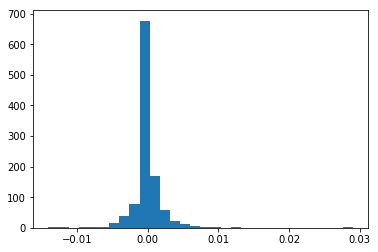

In [14]:
plt.hist(returns, bins=30)

In [15]:
output = 1.0
for y in Ytest:
    output *= (1.0 + y)
output

1.0807582745101103